# **GWP1_#7732 Notebook**

**Introduction:** This notebook contains the python code that addresses the **Sensitivity to Outliers** challenges.











In [16]:
#Importing libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
from scipy import stats
from sklearn.linear_model import LinearRegression, HuberRegressor, TheilSenRegressor, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

## **Challenge 3: Sensitivity to Outliers**

In [17]:
# Fetching Data
tickers = ['AAPL', 'XOM', 'PG', '^GSPC']  # Stocks and S&P 500
start_date = "2018-01-01"
end_date = "2024-10-31"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data = data.pct_change().dropna() * 100

# Portfolio stocks and the S&P 500
portfolio = data[['AAPL', 'XOM', 'PG']]
benchmark = data['^GSPC']
benchmark.name = 'S&P 500'
benchmark = benchmark.to_frame()

[*********************100%***********************]  4 of 4 completed


In [18]:
# Outlier simulation parameters
num_outliers = 70
outlier_magnitude_std = 2
outlier_directions = np.random.choice([-1, 1], size=num_outliers)

# Randomly select indices for outliers
outlier_indices = np.random.choice(portfolio.shape[0], size=num_outliers, replace=False)

# Generate outlier magnitudes
outlier_magnitude_portfolio = np.random.normal(0, 1, size=num_outliers)
outlier_magnitude_benchmark = np.random.normal(0, 1, size=num_outliers)
outlier_magnitude = np.random.normal(0, outlier_magnitude_std, size=num_outliers)

# Introduce outliers into portfolio and benchmark
portfolio.iloc[outlier_indices, 0] += outlier_magnitude * outlier_directions
portfolio.iloc[outlier_indices, 1] += outlier_magnitude * 1.1 * outlier_directions
portfolio.iloc[outlier_indices, 2] += outlier_magnitude * 0.9 * outlier_directions
benchmark.iloc[outlier_indices, 0] += outlier_magnitude * outlier_directions

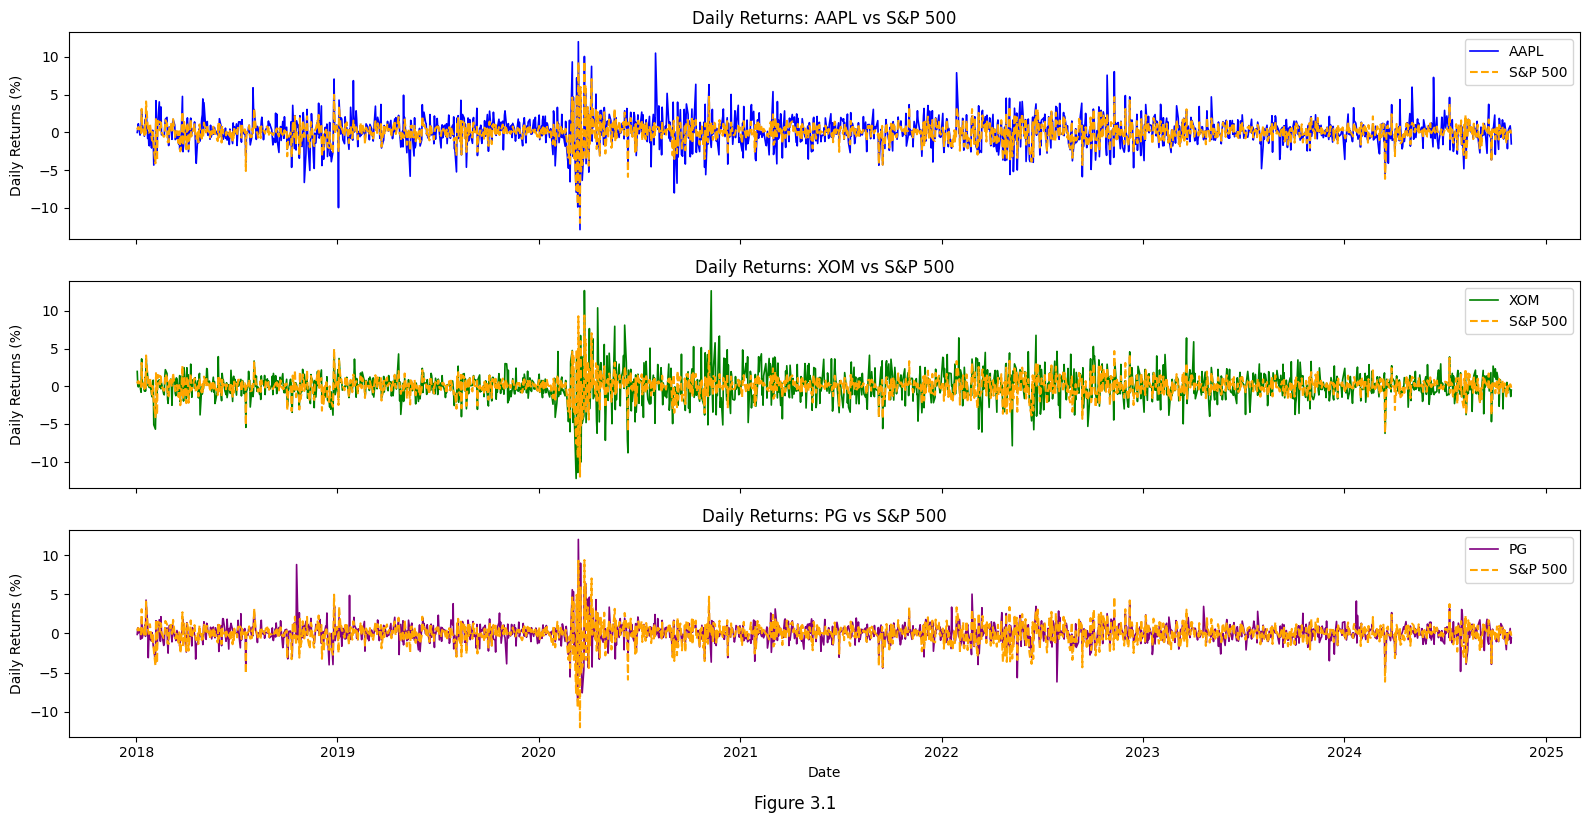

In [19]:
# Visualizing returns with a grid layout (no loop, different colors)
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)

# Plot AAPL vs S&P 500
axes[0].plot(portfolio['AAPL'], label='AAPL', color='blue', linewidth=1.2)
axes[0].plot(benchmark, linestyle='--', label='S&P 500',  color='orange', linewidth=1.5)
axes[0].set_title('Daily Returns: AAPL vs S&P 500')
axes[0].set_ylabel('Daily Returns (%)')
axes[0].legend()

# Plot XOM vs S&P 500
axes[1].plot(portfolio['XOM'], label='XOM', color='green', linewidth=1.2)
axes[1].plot(benchmark, linestyle='--', label='S&P 500',  color='orange', linewidth=1.5)
axes[1].set_title('Daily Returns: XOM vs S&P 500')
axes[1].set_ylabel('Daily Returns (%)')
axes[1].legend()

# Plot PG vs S&P 500
axes[2].plot(portfolio['PG'], label='PG', color='#800080', linewidth=1.2)
axes[2].plot(benchmark, linestyle='--', label='S&P 500', color='orange', linewidth=1.5)
axes[2].set_title('Daily Returns: PG vs S&P 500')
axes[2].set_ylabel('Daily Returns (%)')
axes[2].legend()

# Shared x-axis label
plt.xlabel('Date')
plt.tight_layout()
plt.suptitle("Figure 3.1",y=0)
plt.show()

**Explaination:**

In **Figure 3.1**

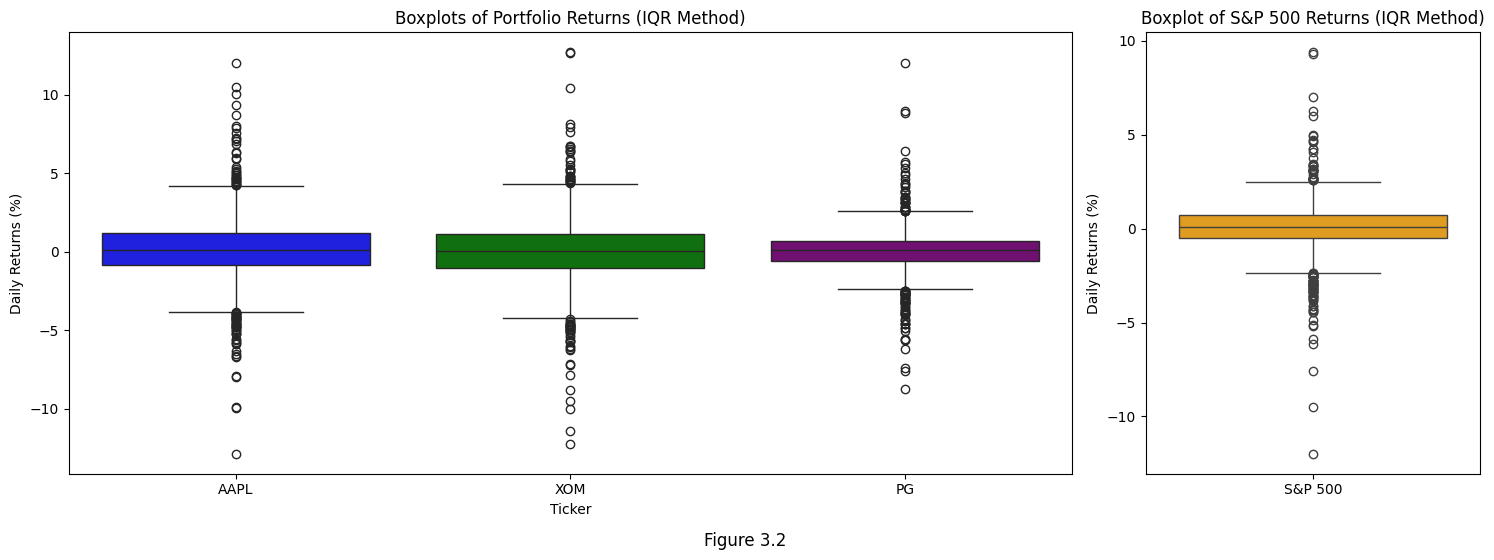

In [20]:
# Visualizing outliers with boxplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6),gridspec_kw={'width_ratios': [3, 1]})
sns.boxplot(data=portfolio, palette=['blue', 'green', '#800080'], ax=axs[0])
axs[0].set_title('Boxplots of Portfolio Returns (IQR Method)')
axs[0].set_ylabel('Daily Returns (%)')

# Visualizing outliers for benchmark (right subplot)
sns.boxplot(benchmark, color='orange', ax=axs[1])
axs[1].set_title('Boxplot of S&P 500 Returns (IQR Method)')
axs[1].set_ylabel('Daily Returns (%)')

# Shared suptitle
plt.suptitle("Figure 3.2", y=0.0)

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

**Explaination:**

In **Figure 3.2**

In [21]:
# Calculate modified Z-scores, handling NaNs
modified_z_scores = 0.6745 * (portfolio.fillna(portfolio.median()) - portfolio.median()) / stats.median_abs_deviation(portfolio.fillna(portfolio.median()))
# Identify outliers using modified Z-score threshold (|Z| > 2.5 or 3.5)
outlier_threshold = 3
portfolio_outliers = (np.abs(modified_z_scores) > outlier_threshold).astype(int)
# Filter out outliers
portfolio_filtered = portfolio[(np.abs(modified_z_scores) <= outlier_threshold)]
# Explicit null handling for portfolio
portfolio_filtered = portfolio_filtered.fillna(portfolio_filtered.median())

modified_z_scores_benchmark = 0.6745 * (benchmark.fillna(benchmark.median()) - benchmark.median()) / stats.median_abs_deviation(benchmark.fillna(benchmark.median()))
# Identify outliers using modified Z-score threshold (|Z| > 2.5 or 3.5)
outlier_threshold_benchmark = 3
# Create outliers mask
benchmark_outliers = (np.abs(modified_z_scores_benchmark) > outlier_threshold_benchmark).astype(int)
# Filter out outliers
benchmark_filtered = benchmark[(np.abs(modified_z_scores_benchmark) <= outlier_threshold_benchmark)]
# Explicit null handling for benchmark
benchmark_filtered = benchmark_filtered.fillna(benchmark_filtered.median())

outliers_before_portfolio = (np.abs(modified_z_scores) > outlier_threshold).sum()
outliers_after_portfolio = (np.abs(modified_z_scores[portfolio_outliers == 0]) > outlier_threshold).sum()
outlier_reduction_portfolio = (outliers_before_portfolio - outliers_after_portfolio) / outliers_before_portfolio * 100

outliers_before_benchmark = (np.abs(modified_z_scores_benchmark) > outlier_threshold_benchmark).sum()
outliers_after_benchmark = (np.abs(modified_z_scores_benchmark[benchmark_outliers == 0]) > outlier_threshold_benchmark).sum()
outlier_reduction_benchmark = (outliers_before_benchmark - outliers_after_benchmark) / outliers_before_benchmark * 100

print("Outlier Analysis:")
print(f"Total outliers in portfolio before filtering: {outliers_before_portfolio.sum()}")
print(f"Total outliers in portfolio after filtering: {outliers_after_portfolio.sum()}")
print(f"Outlier reduction percentage in portfolio: {100:.2f}%")
print()
print(f"Total outliers in benchmark before filtering: {outliers_before_benchmark.sum()}")
print(f"Total outliers in benchmark after filtering: {outliers_after_benchmark.sum()}")
print(f"Outlier reduction percentage in benchmark: {100:.2f}%")

Outlier Analysis:
Total outliers in portfolio before filtering: 182
Total outliers in portfolio after filtering: 0
Outlier reduction percentage in portfolio: 100.00%

Total outliers in benchmark before filtering: 82
Total outliers in benchmark after filtering: 0
Outlier reduction percentage in benchmark: 100.00%


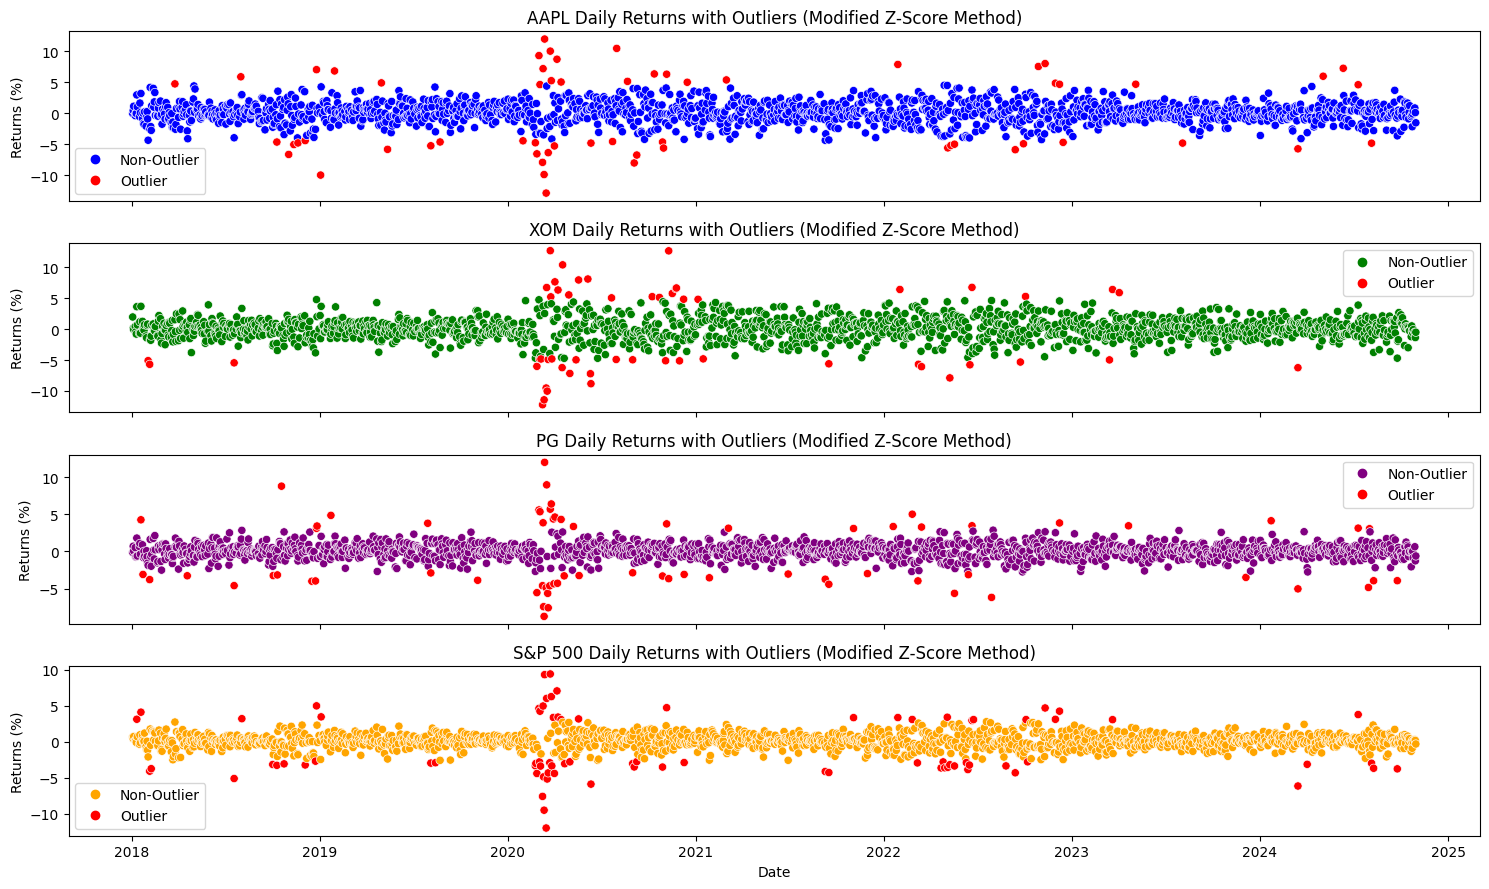

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(15, 9), sharex=True)
# Plot AAPL
sns.scatterplot(x=portfolio.index, y=portfolio['AAPL'], hue=portfolio_outliers['AAPL'], palette={0: 'blue', 1: 'red'}, ax=axes[0])
axes[0].set_title('AAPL Daily Returns with Outliers (Modified Z-Score Method)')
axes[0].set_ylabel('Returns (%)')
handles = [plt.Line2D([], [], marker="o", color="blue", linestyle="", label="Non-Outlier"),
           plt.Line2D([], [], marker="o", color="red", linestyle="", label="Outlier")]
axes[0].legend(handles=handles)

# Plot XOM
sns.scatterplot(x=portfolio.index, y=portfolio['XOM'], hue=portfolio_outliers['XOM'], palette={0: 'green', 1: 'red'}, ax=axes[1])
axes[1].set_title('XOM Daily Returns with Outliers (Modified Z-Score Method)')
axes[1].set_ylabel('Returns (%)')
handles = [plt.Line2D([], [], marker="o", color="green", linestyle="", label="Non-Outlier"),
           plt.Line2D([], [], marker="o", color="red", linestyle="", label="Outlier")]
axes[1].legend(handles=handles)

# Plot PG
sns.scatterplot(x=portfolio.index, y=portfolio['PG'], hue=portfolio_outliers['PG'], palette={0: '#800080', 1: 'red'}, ax=axes[2])
axes[2].set_title('PG Daily Returns with Outliers (Modified Z-Score Method)')
axes[2].set_ylabel('Returns (%)')
handles = [plt.Line2D([], [], marker="o", color="#800080", linestyle="", label="Non-Outlier"),
           plt.Line2D([], [], marker="o", color="red", linestyle="", label="Outlier")]
axes[2].legend(handles=handles)

# Visualize S&P 500
sns.scatterplot(x=benchmark.index, y=benchmark['S&P 500'], hue=benchmark_outliers['S&P 500'], palette={0: 'orange', 1: 'red'}, ax=axes[3])
axes[3].set_title('S&P 500 Daily Returns with Outliers (Modified Z-Score Method)')
axes[3].set_ylabel('Returns (%)')
handles = [plt.Line2D([], [], marker="o", color="orange", linestyle="", label="Non-Outlier"),
           plt.Line2D([], [], marker="o", color="red", linestyle="", label="Outlier")]
axes[3].legend(handles=handles)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

**Explaination:**

In **Figure 3.3**

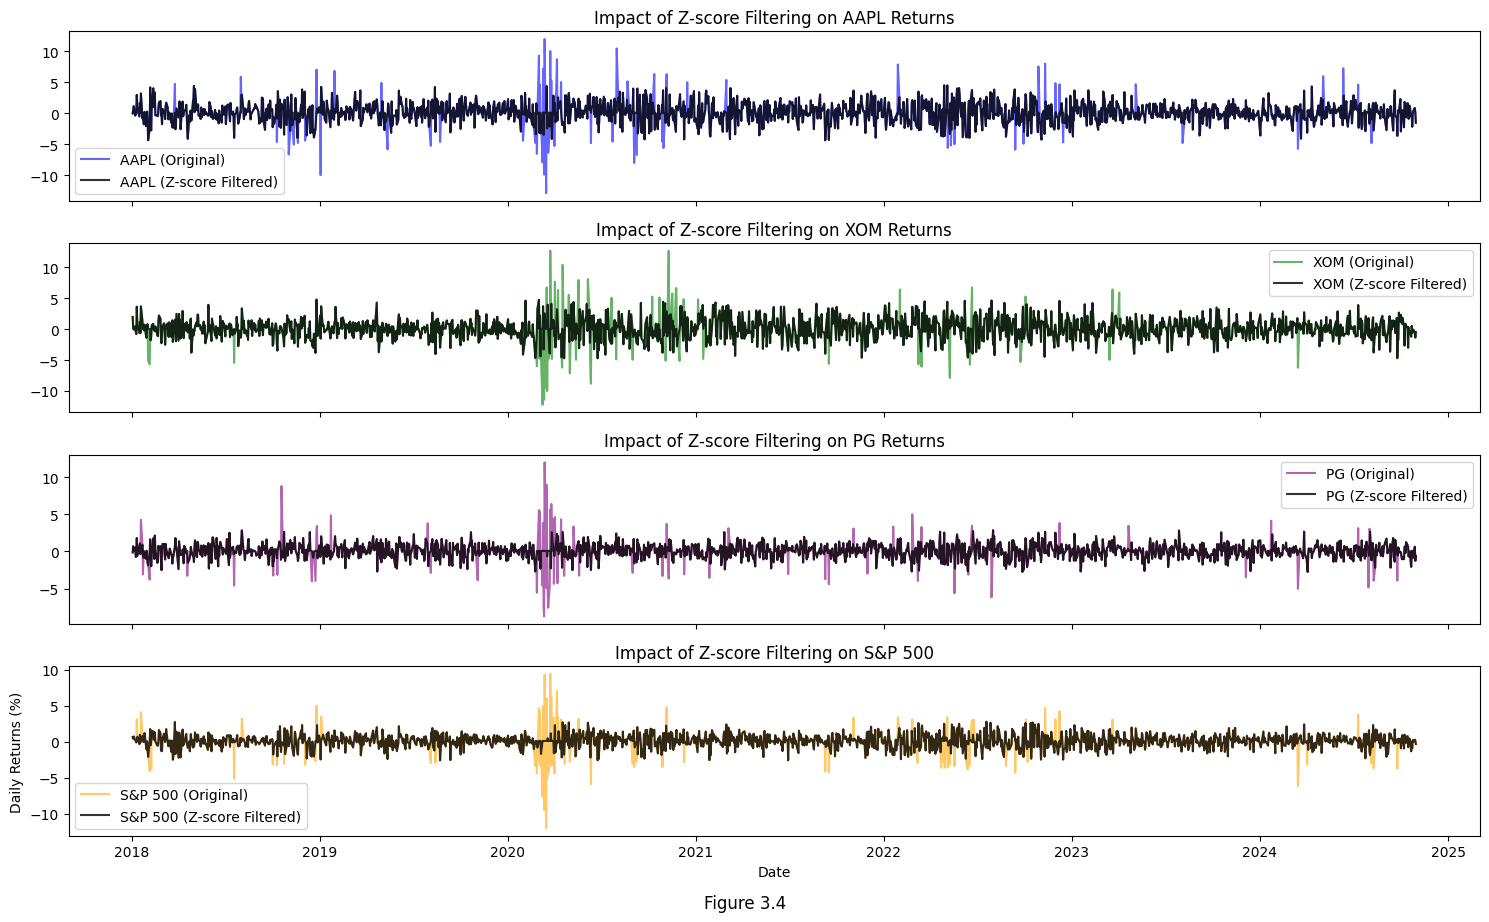

In [23]:
fig, axes = plt.subplots(4, 1, figsize=(15, 9), sharex=True)

# Plot for AAPL
axes[0].plot(portfolio['AAPL'], label='AAPL (Original)', alpha=0.6, color='blue')
axes[0].plot(portfolio_filtered['AAPL'], label='AAPL (Z-score Filtered)', alpha=0.8, color='black')
axes[0].legend()
axes[0].set_title('Impact of Z-score Filtering on AAPL Returns')

# Plot for XOM
axes[1].plot(portfolio['XOM'], label='XOM (Original)', alpha=0.6, color='green')
axes[1].plot(portfolio_filtered['XOM'], label='XOM (Z-score Filtered)', alpha=0.8, color='black')
axes[1].legend()
axes[1].set_title('Impact of Z-score Filtering on XOM Returns')

# Plot for PG
axes[2].plot(portfolio['PG'], label='PG (Original)', alpha=0.6, color='#800080')
axes[2].plot(portfolio_filtered['PG'], label='PG (Z-score Filtered)', alpha=0.8, color='black')
axes[2].legend()
axes[2].set_title('Impact of Z-score Filtering on PG Returns')

# Plot for S&P 500
axes[3].plot(benchmark, label='S&P 500 (Original)', alpha=0.6, color='#FFA500')
axes[3].plot(benchmark_filtered, label='S&P 500 (Z-score Filtered)', alpha=0.8, color='black')
axes[3].legend()
axes[3].set_title('Impact of Z-score Filtering on S&P 500')

plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.tight_layout()
plt.suptitle("Figure 3.4",y=0)
plt.show()

**Explaination:**

In **Figure 3.4**

In [24]:
# ----- Models to Demonstrate Outlier Sensitivity -----
data_raw = portfolio.copy()
data_raw['SP500'] = benchmark

data_transformed = portfolio_filtered.copy()
data_transformed['SP500'] = benchmark_filtered

In [25]:
# Splitting the data for models
X_raw, y_raw = data_raw['SP500'], data_raw[['AAPL','XOM','PG']].mean(axis=1)  # Benchmark as input, portfolio avg as output
X_trans, y_trans = data_transformed['SP500'], data_transformed[['AAPL','XOM','PG']].mean(axis=1)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_trans, test_size=0.2, random_state=42)

In [26]:
def evaluate_models_with_tuning(models_raw, models_trans, param_grids, X_train_raw, X_test_raw, y_train_raw, y_test_raw,
                                 X_train_trans, X_test_trans, y_train_trans, y_test_trans):
    """
    Evaluates raw and transformed models with hyperparameter tuning for Lasso and ElasticNet,
    returns a cleaner results DataFrame, and plots both datasets together.
    """
    # Initialize a list to store results in the desired format
    results = []

    # List of metrics to calculate
    metrics = ["MSE", "MAE", "R²", "RMSLE", "MAPE (%)"]

    # Iterate through models for evaluation
    for model_name, model_raw, model_trans, param_grid in zip(models_raw.keys(), models_raw.values(), models_trans.values(), param_grids.values()):
        # Grid Search for hyperparameter tuning (if applicable)
        if model_name in ["Lasso", "ElasticNet"]:
            grid_search_raw = GridSearchCV(model_raw, param_grid, cv=5)
            grid_search_trans = GridSearchCV(model_trans, param_grid, cv=5)

            # Fit grid search models
            grid_search_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw.values)
            grid_search_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans.values)

            # Use best estimators
            best_model_raw = grid_search_raw.best_estimator_
            best_model_trans = grid_search_trans.best_estimator_
        else:
            best_model_raw = model_raw
            best_model_trans = model_trans

        # Raw data model evaluation
        best_model_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw)
        predictions_raw = best_model_raw.predict(X_test_raw.values.reshape(-1, 1))

        mse_raw = mean_squared_error(y_test_raw, predictions_raw)
        mae_raw = mean_absolute_error(y_test_raw, predictions_raw)
        r2_raw = r2_score(y_test_raw, predictions_raw)
        rmsle_raw = sqrt(np.mean((np.log(y_test_raw + 1) - np.log(predictions_raw + 1))**2))
        mape_raw = np.mean(np.abs((y_test_raw - predictions_raw) / y_test_raw)) * 100

        # Transformed data model evaluation
        best_model_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans)
        predictions_trans = best_model_trans.predict(X_test_trans.values.reshape(-1, 1))

        mse_trans = mean_squared_error(y_test_trans, predictions_trans)
        mae_trans = mean_absolute_error(y_test_trans, predictions_trans)
        r2_trans = r2_score(y_test_trans, predictions_trans)
        rmsle_trans = sqrt(np.mean((np.log(y_test_trans + 1) - np.log(predictions_trans + 1))**2))
        mape_trans = np.mean(np.abs((y_test_trans - predictions_trans) / y_test_trans)) * 100

        # Add raw and transformed data results for each model and metric
        for metric, metric_raw, metric_trans in zip(metrics,
                                                     [mse_raw, mae_raw, r2_raw, rmsle_raw, mape_raw],
                                                     [mse_trans, mae_trans, r2_trans, rmsle_trans, mape_trans]):
            results.append({"Model": model_name, "Data": "Raw", "Metric": f"{metric} - Raw", "Value": metric_raw})
            results.append({"Model": model_name, "Data": "Transformed", "Metric": f"{metric} - Transformed", "Value": metric_trans})

        # Plot predictions for both raw and transformed data
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_raw, predictions_raw, alpha=0.6, label='Raw Data Predictions', color='blue')
        plt.scatter(y_test_trans, predictions_trans, alpha=0.6, label='Transformed Data Predictions', color='orange')
        plt.plot([min(y_test_raw.min(), y_test_trans.min()), max(y_test_raw.max(), y_test_trans.max())],
                 [min(y_test_raw.min(), y_test_trans.min()), max(y_test_raw.max(), y_test_trans.max())],
                 color='red', linestyle='--', label='Ideal Line')
        plt.title(f"{model_name} Predictions: Raw vs Transformed")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Pivot the DataFrame to have the structure with models as columns
    results_pivoted = results_df.pivot_table(index=["Metric"], columns=["Model"], values="Value", aggfunc="first")

    return results_pivoted


In [27]:
def evaluate_models_with_tuning(models_raw, models_trans, param_grids, X_train_raw, X_test_raw, y_train_raw, y_test_raw,
                                 X_train_trans, X_test_trans, y_train_trans, y_test_trans):
    """
    Evaluates raw and transformed models with hyperparameter tuning for Lasso and ElasticNet,
    returns a cleaner results DataFrame, and plots both datasets together.
    """
    # Initialize a list to store results in the desired format
    results = []

    # List of metrics to calculate
    metrics = ["MSE", "MAE", "R²", "RMSLE", "MAPE (%)"]

    # Iterate through models for evaluation
    for model_name, model_raw, model_trans, param_grid in zip(models_raw.keys(), models_raw.values(), models_trans.values(), param_grids.values()):
        # Grid Search for hyperparameter tuning (if applicable)
        if model_name in ["Lasso", "ElasticNet"]:
            grid_search_raw = GridSearchCV(model_raw, param_grid, cv=5)
            grid_search_trans = GridSearchCV(model_trans, param_grid, cv=5)

            # Fit grid search models
            grid_search_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw.values)
            grid_search_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans.values)

            # Use best estimators
            best_model_raw = grid_search_raw.best_estimator_
            best_model_trans = grid_search_trans.best_estimator_
        else:
            best_model_raw = model_raw
            best_model_trans = model_trans

        # Raw data model evaluation
        best_model_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw)
        predictions_raw = best_model_raw.predict(X_test_raw.values.reshape(-1, 1))

        mse_raw = mean_squared_error(y_test_raw, predictions_raw)
        mae_raw = mean_absolute_error(y_test_raw, predictions_raw)
        r2_raw = r2_score(y_test_raw, predictions_raw)
        rmsle_raw = sqrt(np.mean((np.log(y_test_raw + 1) - np.log(predictions_raw + 1))**2))
        mape_raw = np.mean(np.abs((y_test_raw - predictions_raw) / y_test_raw)) * 100

        # Transformed data model evaluation
        best_model_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans)
        predictions_trans = best_model_trans.predict(X_test_trans.values.reshape(-1, 1))

        mse_trans = mean_squared_error(y_test_trans, predictions_trans)
        mae_trans = mean_absolute_error(y_test_trans, predictions_trans)
        r2_trans = r2_score(y_test_trans, predictions_trans)
        rmsle_trans = sqrt(np.mean((np.log(y_test_trans + 1) - np.log(predictions_trans + 1))**2))
        mape_trans = np.mean(np.abs((y_test_trans - predictions_trans) / y_test_trans)) * 100

        # Add raw and transformed data results for each model and metric
        for metric, metric_raw, metric_trans in zip(metrics,
                                                     [mse_raw, mae_raw, r2_raw, rmsle_raw, mape_raw],
                                                     [mse_trans, mae_trans, r2_trans, rmsle_trans, mape_trans]):
            results.append({"Model": model_name, "Data": "Raw", "Metric": f"{metric} - Raw", "Value": metric_raw})
            results.append({"Model": model_name, "Data": "Transformed", "Metric": f"{metric} - Transformed", "Value": metric_trans})

        # Plot predictions for both raw and transformed data
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_raw, predictions_raw, alpha=0.6, label='Raw Data Predictions', color='blue')
        plt.scatter(y_test_trans, predictions_trans, alpha=0.6, label='Transformed Data Predictions', color='orange')
        plt.plot([min(y_test_raw.min(), y_test_trans.min()), max(y_test_raw.max(), y_test_trans.max())],
                 [min(y_test_raw.min(), y_test_trans.min()), max(y_test_raw.max(), y_test_trans.max())],
                 color='red', linestyle='--', label='Ideal Line')
        plt.title(f"{model_name} Predictions: Raw vs Transformed")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Pivot the DataFrame to have the structure with models as columns
    results_pivoted = results_df.pivot_table(index=["Metric"], columns=["Model"], values="Value", aggfunc="first")

    return results_pivoted


In [34]:
def evaluate_models_with_tuning(models_raw, models_trans, param_grids, X_train_raw, X_test_raw, y_train_raw, y_test_raw,
                                 X_train_trans, X_test_trans, y_train_trans, y_test_trans):
    """
    Evaluates raw and transformed models with hyperparameter tuning for Lasso and ElasticNet,
    returns a cleaner results DataFrame, and plots both datasets together.
    """
    # Initialize a list to store results in the desired format
    results = []

    # List of metrics to calculate
    metrics = ["MSE", "MAE", "R²", "RMSLE", "MAPE (%)"]

    # Prepare the grid layout for the plots (3 rows, 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3x2 grid
    axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

    # Initialize plot counter
    plot_counter = 0


    # Iterate through models for evaluation
    for model_name, model_raw, model_trans, param_grid in zip(models_raw.keys(), models_raw.values(), models_trans.values(), param_grids.values()):
        # Grid Search for hyperparameter tuning (if applicable)
        if model_name in ["Lasso", "ElasticNet"]:
            grid_search_raw = GridSearchCV(model_raw, param_grid, cv=5)
            grid_search_trans = GridSearchCV(model_trans, param_grid, cv=5)

            # Fit grid search models
            grid_search_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw.values)
            grid_search_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans.values)

            # Use best estimators
            best_model_raw = grid_search_raw.best_estimator_
            best_model_trans = grid_search_trans.best_estimator_
        else:
            best_model_raw = model_raw
            best_model_trans = model_trans

        # Raw data model evaluation
        best_model_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw)
        predictions_raw = best_model_raw.predict(X_test_raw.values.reshape(-1, 1))

        mse_raw = mean_squared_error(y_test_raw, predictions_raw)
        mae_raw = mean_absolute_error(y_test_raw, predictions_raw)
        r2_raw = r2_score(y_test_raw, predictions_raw)
        rmsle_raw = sqrt(np.mean((np.log(y_test_raw + 1) - np.log(predictions_raw + 1))**2))
        mape_raw = np.mean(np.abs((y_test_raw - predictions_raw) / y_test_raw)) * 100

        # Transformed data model evaluation
        best_model_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans)
        predictions_trans = best_model_trans.predict(X_test_trans.values.reshape(-1, 1))

        mse_trans = mean_squared_error(y_test_trans, predictions_trans)
        mae_trans = mean_absolute_error(y_test_trans, predictions_trans)
        r2_trans = r2_score(y_test_trans, predictions_trans)
        rmsle_trans = sqrt(np.mean((np.log(y_test_trans + 1) - np.log(predictions_trans + 1))**2))
        mape_trans = np.mean(np.abs((y_test_trans - predictions_trans) / y_test_trans)) * 100

        # Add raw and transformed data results for each model and metric
        for metric, metric_raw, metric_trans in zip(metrics,
                                                     [mse_raw, mae_raw, r2_raw, rmsle_raw, mape_raw],
                                                     [mse_trans, mae_trans, r2_trans, rmsle_trans, mape_trans]):
            results.append({"Model": model_name, "Data": "Raw", "Metric": f"{metric} - Raw", "Value": round(metric_raw,4)})
            results.append({"Model": model_name, "Data": "Transformed", "Metric": f"{metric} - Transformed", "Value": round(metric_trans,4)})

       # Plot predictions for both raw and transformed data
        ax = axes[plot_counter]
        ax.scatter(y_test_raw, predictions_raw, alpha=0.6, label=f'Raw Data Predictions (R²: {r2_raw:.2f})', color='blue')
        ax.scatter(y_test_trans, predictions_trans, alpha=0.6, label=f'Transformed Data Predictions (R²: {r2_trans:.2f})', color='orange')
        ax.plot([min(y_test_raw.min(), y_test_trans.min()), max(y_test_raw.max(), y_test_trans.max())],
                [min(y_test_raw.min(), y_test_trans.min()), max(y_test_raw.max(), y_test_trans.max())],
                color='red', linestyle='--', label='Ideal Line')
        ax.set_title(f"{model_name} Predictions: Raw vs Transformed")
        ax.set_xlabel("Actual Values")
        ax.set_ylabel("Predicted Values")
        ax.legend()
        ax.grid(True)

        # Update plot counter
        plot_counter += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Pivot the DataFrame to have the structure with models as columns
    results_pivoted = results_df.pivot_table(index=["Metric"], columns=["Model"], values="Value", aggfunc="first")

    return results_pivoted


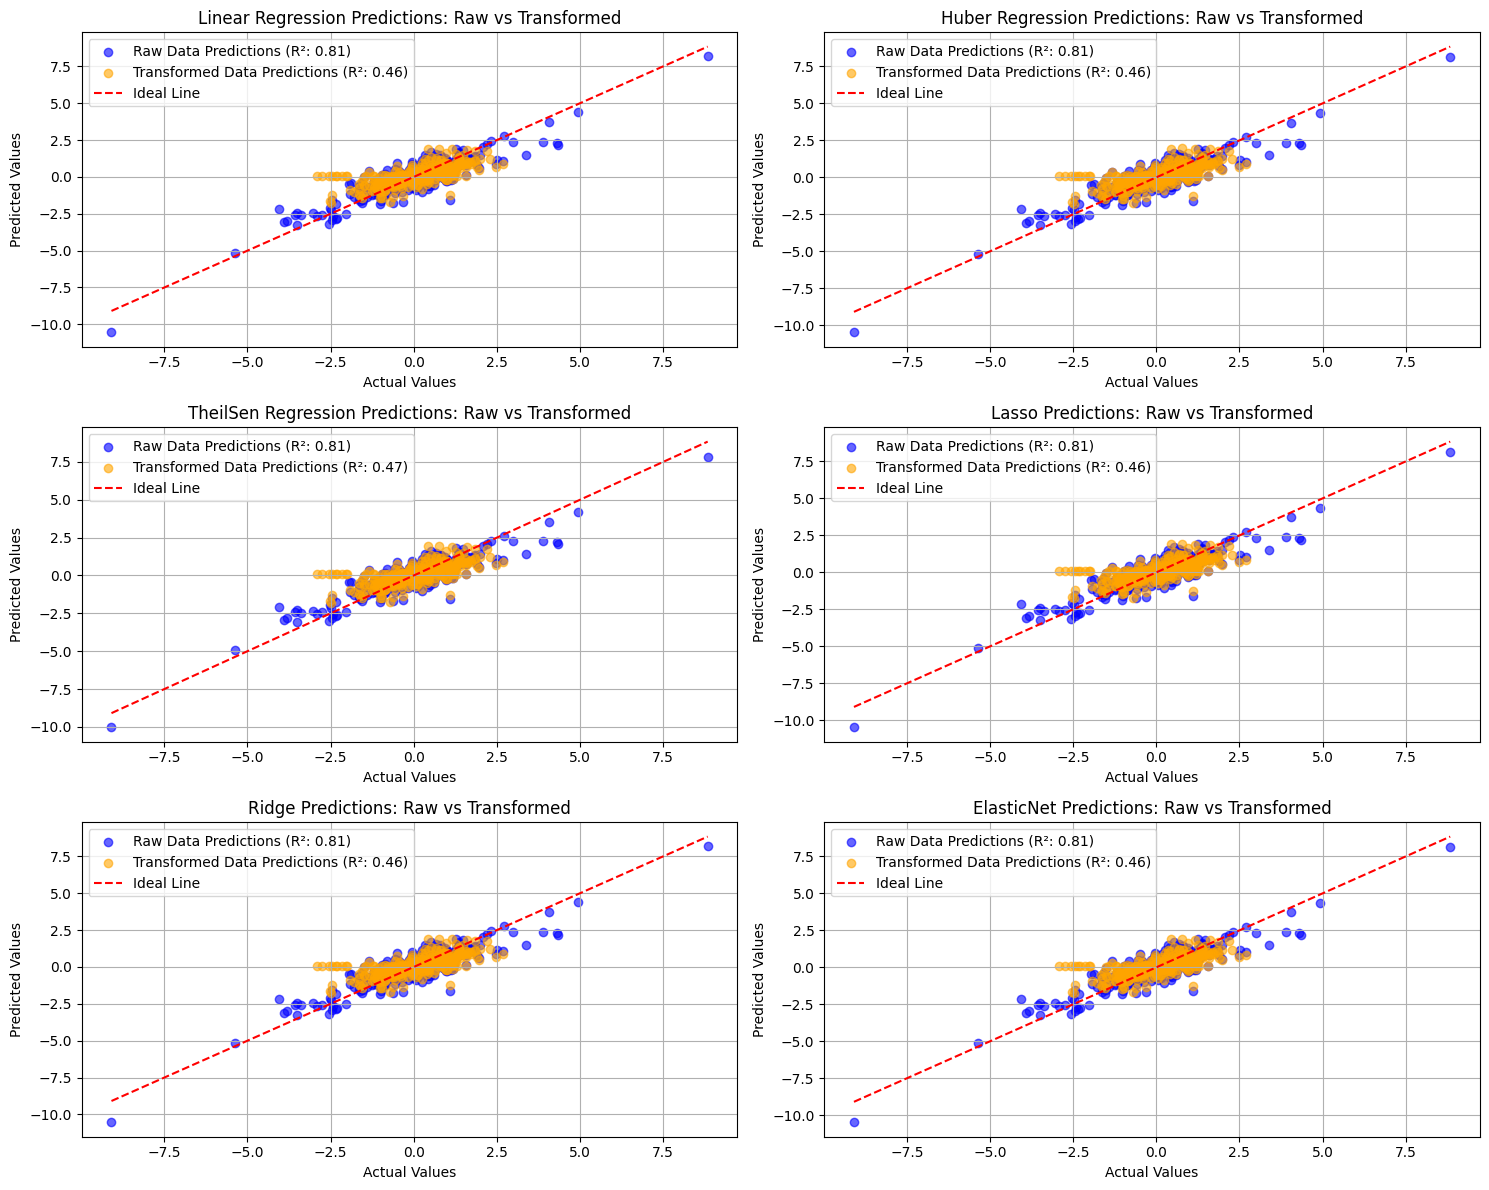

In [35]:
# Define models and hyperparameter tuning grids
models_raw = {
    "Linear Regression": LinearRegression(),
    "Huber Regression": HuberRegressor(),
    "TheilSen Regression": TheilSenRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet()
}

models_trans = {
    "Linear Regression": LinearRegression(),
    "Huber Regression": HuberRegressor(),
    "TheilSen Regression": TheilSenRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet()
}

param_grids = {
    "Linear Regression": None,  # No hyperparameters to tune
    "Huber Regression": None,
    "TheilSen Regression": None,
    "Lasso": {"alpha": [0.001, 0.01, 0.1, 1, 10]},
    "Ridge": None,
    "ElasticNet": {"alpha": [0.001, 0.01, 0.1, 1, 10], "l1_ratio": [0.1, 0.5, 0.9]}
}

# Evaluate models with hyperparameter tuning
results = evaluate_models_with_tuning(
    models_raw, models_trans, param_grids,
    X_train_raw, X_test_raw, y_train_raw, y_test_raw,
    X_train_trans, X_test_trans, y_train_trans, y_test_trans
)

In [30]:
print("Model Evaluation Results:\n")
print(results.to_string(index=True))

Model Evaluation Results:

Model                   ElasticNet  Huber Regression       Lasso  Linear Regression       Ridge  TheilSen Regression
Metric                                                                                                              
MAE - Raw                 0.486458          0.486386    0.486493           0.486234    0.486248             0.490383
MAE - Transformed         0.516495          0.515480    0.516509           0.516418    0.516464             0.515110
MAPE (%) - Raw          170.611254        169.343969  170.515507         171.380926  171.325293           162.727949
MAPE (%) - Transformed  149.834034        151.497266  149.810739         149.964821  149.886542           152.143479
MSE - Raw                 0.413683          0.414530    0.413707           0.413557    0.413561             0.421035
MSE - Transformed         0.512520          0.511836    0.512528           0.512478    0.512503             0.511455
RMSLE - Raw               0.696274   

In [33]:
# Initialize dictionaries for GridSearchCV results
delta_x_raw = np.random.normal(0, 1, len(X_test_raw))
delta_x_trans = np.random.normal(0, 1, len(X_test_trans))

# Sensitivity formula implementation
def sensitivity_to_outliers(estimator, x, delta_x, epsilon=1e-5):
    perturbed_x = x + epsilon * delta_x
    unperturbed_result = estimator.predict(x.reshape(-1, 1))
    perturbed_result = estimator.predict(perturbed_x.reshape(-1, 1))
    sensitivity = (perturbed_result - unperturbed_result) / epsilon
    return np.mean(sensitivity)



grid_search_raws = {}
grid_search_transformed = {}  # Changed this variable name to avoid overwriting

# Run GridSearchCV for Lasso and ElasticNet models
for model_name, model_raw, model_trans, param_grid in zip(models_raw.keys(), models_raw.values(), models_trans.values(), param_grids.values()):
    # For Lasso and ElasticNet, perform GridSearchCV to tune hyperparameters
    if model_name in ['Lasso', 'ElasticNet']:
        grid_search_raw = GridSearchCV(model_raw, param_grid, cv=5)
        grid_search_trans = GridSearchCV(model_trans, param_grid, cv=5)

        # Fit the grid search
        grid_search_raw.fit(X_train_raw.values.reshape(-1, 1), y_train_raw)
        grid_search_trans.fit(X_train_trans.values.reshape(-1, 1), y_train_trans)

        # Store grid search results
        grid_search_raws[model_name] = grid_search_raw
        grid_search_transformed[model_name] = grid_search_trans  # Store the transformed grid search results in the new dictionary

# Initialize lists to store sensitivity scores
sensitivity_raw_scores = []
sensitivity_trans_scores = []

# Iterate over the raw models and transformed models to calculate sensitivity scores
for model_name, model_raw, model_trans in zip(models_raw.keys(), models_raw.values(), models_trans.values()):
    # Retrieve the best model from grid search if applicable
    if model_name in ['Lasso', 'ElasticNet']:
        best_model_raw = grid_search_raws[model_name].best_estimator_
        best_model_trans = grid_search_transformed[model_name].best_estimator_  # Retrieve the transformed model from the new dictionary
    else:
        best_model_raw = model_raw
        best_model_trans = model_trans

    # For raw data model sensitivity calculation
    sensitivity_raw = round(sensitivity_to_outliers(best_model_raw, X_test_raw.values, delta_x_raw),4)
    sensitivity_raw_scores.append(sensitivity_raw)

    # For transformed data model sensitivity calculation
    sensitivity_trans = round(sensitivity_to_outliers(best_model_trans, X_test_trans.values, delta_x_trans),4)
    sensitivity_trans_scores.append(sensitivity_trans)

# Create DataFrame with sensitivity analysis results
sensitivity_scores = pd.DataFrame({
    'Model': models_raw.keys(),  # Assuming models_raw.keys() has the model names
    'Raw Data Sensitivity': sensitivity_raw_scores,
    'Transformed Data Sensitivity': sensitivity_trans_scores,
})

# Print DataFrame
print("Sensitivity Analysis Results:\n")
print(sensitivity_scores.to_string(index=False))


Sensitivity Analysis Results:

              Model  Raw Data Sensitivity  Transformed Data Sensitivity
  Linear Regression                0.0556                        0.0274
   Huber Regression                0.0552                        0.0279
TheilSen Regression                0.0524                        0.0282
              Lasso                0.0552                        0.0273
              Ridge                0.0555                        0.0273
         ElasticNet                0.0552                        0.0273


In [36]:
# Calculate cross-validation scores
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the cross-validation results
cross_val_scores_raw = []
cross_val_scores_trans = []

# Compute cross-validation scores for each model (raw data)
for model_name, model_raw in models_raw.items():
    score_raw = np.mean(-cross_val_score(model_raw, X_train_raw.values.reshape(-1, 1), y_train_raw, cv=kf, scoring='neg_mean_squared_error'))
    cross_val_scores_raw.append(score_raw)

# Compute cross-validation scores for each model (transformed data)
for model_name, model_trans in models_trans.items():
    score_trans = np.mean(-cross_val_score(model_trans, X_train_trans.values.reshape(-1, 1), y_train_trans, cv=kf, scoring='neg_mean_squared_error'))
    cross_val_scores_trans.append(score_trans)

# Create the DataFrame for cross-validation scores
cross_val_scores = pd.DataFrame({
    'Model': list(models_raw.keys()),  # Assumes models_raw and models_trans are aligned
    'Raw Data': cross_val_scores_raw,
    'Transformed Data': cross_val_scores_trans
})

# Print the DataFrame
print("Cross-validation scores:\n")
print(cross_val_scores.to_string(index=False))

Cross-validation scores:

              Model  Raw Data  Transformed Data
  Linear Regression  0.465501          0.497647
   Huber Regression  0.465266          0.496920
TheilSen Regression  0.468175          0.496504
              Lasso  1.092474          0.899473
              Ridge  0.465505          0.497648
         ElasticNet  0.789699          0.838048


In [39]:
from tabulate import tabulate


# Print fancy table with lines after every two rows
table = tabulate(results.head(10), headers='keys', tablefmt='psql')
rows = table.split('\n')
new_table = ''
for i, row in enumerate(rows,):
    new_table += row + '\n'
    if i!= 0 and (i + 2) % 2 == 0 and i != len(rows) - 2 :
        new_table += '-' * len(row) + '\n'
print(new_table)


+------------------------+--------------+--------------------+----------+---------------------+----------+-----------------------+
| Metric                 |   ElasticNet |   Huber Regression |    Lasso |   Linear Regression |    Ridge |   TheilSen Regression |
|------------------------+--------------+--------------------+----------+---------------------+----------+-----------------------|
----------------------------------------------------------------------------------------------------------------------------------
| MAE - Raw              |       0.4865 |             0.4864 |   0.4865 |              0.4862 |   0.4862 |                0.4895 |
| MAE - Transformed      |       0.5165 |             0.5155 |   0.5165 |              0.5164 |   0.5165 |                0.5155 |
----------------------------------------------------------------------------------------------------------------------------------
| MAPE (%) - Raw         |     170.611  |           169.344  | 170.516  |          

In [38]:
# Calculate cross-validation scores
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the cross-validation results
cross_val_scores_raw = []
cross_val_scores_trans = []

# Compute cross-validation scores for each model (raw data)
for model_name, model_raw in models_raw.items():
    score_raw = np.mean(-cross_val_score(model_raw, X_train_raw.values.reshape(-1, 1), y_train_raw, cv=kf, scoring='neg_mean_squared_error'))
    cross_val_scores_raw.append(score_raw)

# Compute cross-validation scores for each model (transformed data)
for model_name, model_trans in models_trans.items():
    score_trans = np.mean(-cross_val_score(model_trans, X_train_trans.values.reshape(-1, 1), y_train_trans, cv=kf, scoring='neg_mean_squared_error'))
    cross_val_scores_trans.append(score_trans)

# Create the DataFrame for cross-validation scores
cross_val_scores = pd.DataFrame({
    'Model': list(models_raw.keys()),  # Assumes models_raw and models_trans are aligned
    'Raw Data': cross_val_scores_raw,
    'Transformed Data': cross_val_scores_trans
})

# Print the DataFrame
print("Cross-validation scores:\n")
print(cross_val_scores.to_string(index=False))

Cross-validation scores:

              Model  Raw Data  Transformed Data
  Linear Regression  0.465501          0.497647
   Huber Regression  0.465266          0.496920
TheilSen Regression  0.470736          0.497052
              Lasso  1.092474          0.899473
              Ridge  0.465505          0.497648
         ElasticNet  0.789699          0.838048


**Summary:**